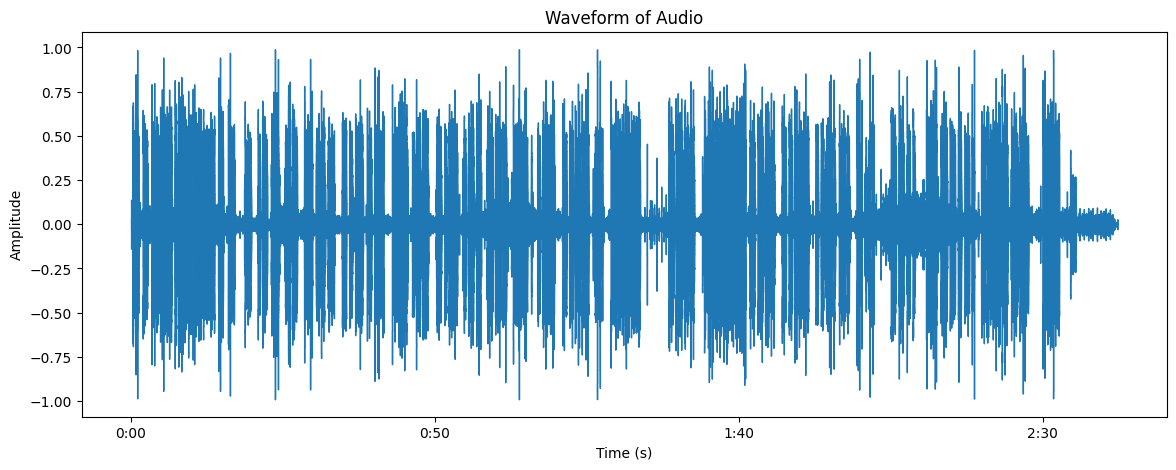

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load audio file
def load_audio(file_path):
    """
    Load an audio file and return the audio time series and sampling rate.

    Parameters:
    - file_path: str, path to the audio file.

    Returns:
    - y: np.ndarray, audio time series.
    - sr: int, sampling rate.
    """
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

# Visualize waveform
def plot_waveform(y, sr):
    """
    Plot the waveform of the audio signal.

    Parameters:
    - y: np.ndarray, audio time series.
    - sr: int, sampling rate.
    """
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform of Audio')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

# Load and plot
file_path = r'C:\Users\syrym\Downloads\research_2\audio.wav'
y, sr = load_audio(file_path)
plot_waveform(y, sr)


In [4]:
def extract_pitch(y, sr, fmin=50, fmax=300):
    """
    Extract the fundamental frequency (F0) of the audio signal using the autocorrelation method.

    Parameters:
    - y: np.ndarray, audio time series.
    - sr: int, sampling rate.
    - fmin: float, minimum frequency to consider (Hz).
    - fmax: float, maximum frequency to consider (Hz).

    Returns:
    - pitches: np.ndarray, pitch (F0) values over time.
    """
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr, fmin=fmin, fmax=fmax)
    
    # Extract pitch for each frame
    pitch_values = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]
        pitch_values.append(pitch if pitch > 0 else np.nan)  # NaN for no pitch detected
    
    return np.array(pitch_values)

# Extract pitch
pitches = extract_pitch(y, sr)


In [5]:
def classify_gender(pitches):
    """
    Classify gender based on average pitch.

    Parameters:
    - pitches: np.ndarray, array of pitch (F0) values.

    Returns:
    - str, predicted gender ('Male' or 'Female').
    """
    avg_pitch = np.nanmean(pitches)
    print(f"Average Pitch: {avg_pitch:.2f} Hz")
    
    if avg_pitch > 165:
        return 'Female'
    else:
        return 'Male'

# Classify gender
predicted_gender = classify_gender(pitches)
print(f"Predicted Gender: {predicted_gender}")


Average Pitch: 165.22 Hz
Predicted Gender: Female


In [7]:
import numpy as np
import librosa
from scipy.signal import lfilter

def extract_formants(y, sr, frame_length=0.025, hop_length=0.01, lpc_order=16):
    """
    Extract the first two formant frequencies (F1, F2) using Linear Predictive Coding (LPC).

    Parameters:
    - y: np.ndarray, audio time series.
    - sr: int, sampling rate.
    - frame_length: float, frame length (seconds).
    - hop_length: float, hop length (seconds).
    - lpc_order: int, order of the LPC filter (default is 16).

    Returns:
    - formants: list of tuples, containing F1 and F2 for each frame.
    """
    n_samples_per_frame = int(frame_length * sr)
    hop_length_samples = int(hop_length * sr)
    formants = []

    for i in range(0, len(y) - n_samples_per_frame, hop_length_samples):
        frame = y[i:i + n_samples_per_frame]

        # Apply LPC
        a = librosa.lpc(frame, order=lpc_order)
        
        # Find the roots of the LPC polynomial
        roots = np.roots(a)

        # Keep only the roots with positive imaginary parts (representing frequencies)
        roots = [r for r in roots if np.imag(r) >= 0]

        # Convert roots to frequencies
        formant_frequencies = np.angle(roots) * (sr / (2 * np.pi))

        # Select the first two formants
        formant_frequencies = np.sort(formant_frequencies)
        if len(formant_frequencies) >= 2:
            formants.append((formant_frequencies[0], formant_frequencies[1]))
    
    return formants

# Usage example:
# Assuming `y` is the audio signal and `sr` is the sampling rate
formants = extract_formants(y, sr)


In [8]:
def extract_mfccs(y, sr, n_mfcc=13):
    """
    Extract Mel-frequency cepstral coefficients (MFCCs) from the audio signal.

    Parameters:
    - y: np.ndarray, audio time series.
    - sr: int, sampling rate.
    - n_mfcc: int, number of MFCCs to extract.

    Returns:
    - mfccs: np.ndarray, MFCC feature matrix.
    """
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Extract MFCCs
mfccs = extract_mfccs(y, sr)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_gender_classifier(X, y):
    """
    Train a logistic regression model for gender classification based on MFCCs.

    Parameters:
    - X: np.ndarray, feature matrix (MFCCs).
    - y: np.ndarray, gender labels (0 for male, 1 for female).

    Returns:
    - model: trained logistic regression model.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test) 
    accuracy = accuracy_score(y_test, y_pred) 
    print(f"Model Accuracy: {accuracy * 100:.2f}%") 
    return model
